### Reading the csv data file and creating a data-frame called churn

In [172]:
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, classification_report, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, RidgeCV



# Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'gabriel-predictive-analytics'
bucket = s3.Bucket(bucket_name)

# Defining the file to be read from s3 bucket
file_key_train = "train.csv"
bucket_object = bucket.Object(file_key_train)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# Reading the csv file
train = pd.read_csv(file_content_stream, sep="|")

# Defining the file to be read from s3 bucket
file_key_test = "test.csv"
bucket_object_test = bucket.Object(file_key_test)
file_object_test = bucket_object_test.get()
file_content_stream_test = file_object_test.get('Body')

# Reading the csv file
test = pd.read_csv(file_content_stream_test, sep='|')

### Test Dataset

In [173]:
test.head(1)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429


In [174]:
test.shape

(498121, 9)

### Train dataset

In [175]:
train.head(10)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
5,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1
6,3,294,55.63,2,7,1,0.037415,0.189218,0.181818,0
7,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0
8,6,962,65.44,7,0,2,0.028067,0.068025,0.259259,0
9,2,725,41.08,10,2,4,0.037241,0.056662,0.370370,0


In [176]:
train.shape

(1879, 10)

### Looking at the relative frequency table of the fraud variable

In [190]:
train['fraud'].value_counts()

0    1775
1     104
Name: fraud, dtype: int64

In [177]:
train['fraud'].value_counts() / train.shape[0]

0    0.944651
1    0.055349
Name: fraud, dtype: float64

As we can see, this is a very unbalanced dataset.

### Creating Exploratory Visualisations

<AxesSubplot:>

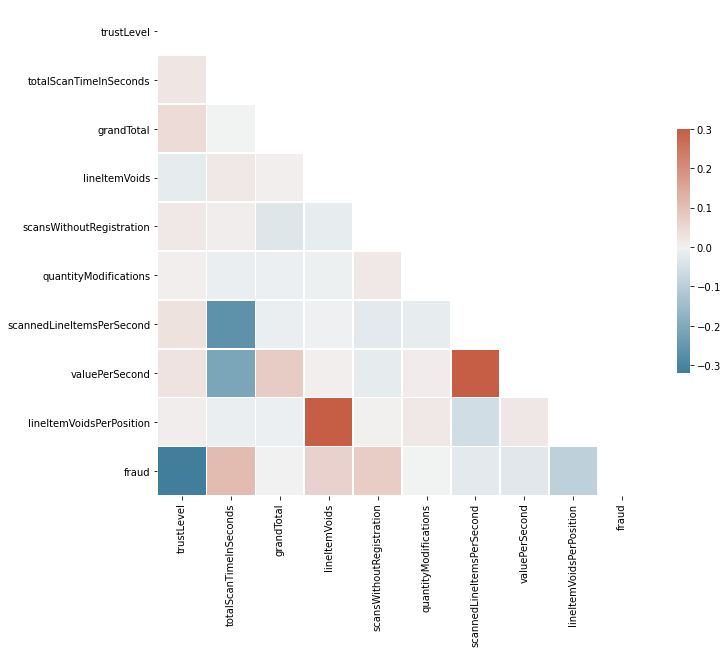

In [178]:
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Here we have a heatmap to have an idea of how the variables correlate with each other.
#### We can see the variable trustLevel is the most correlated to our target variable fraud.

Text(0.5, 0, '0 = Not Fraud | 1 = Fraud')

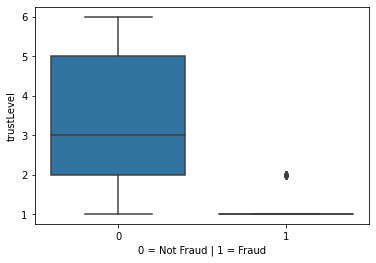

In [179]:
# Boxplot
sns.boxplot( x=train["fraud"], y=train["trustLevel"]).set_xlabel('0 = Not Fraud | 1 = Fraud')

#### In the above box-plot we can see that all fraud transactions had no more than 2 in the trustLevel.

### Building Models

In [180]:
## Selecting input and target variables
X = train[["trustLevel", "totalScanTimeInSeconds", "grandTotal", "lineItemVoids", "scansWithoutRegistration", "quantityModifications", "scannedLineItemsPerSecond", 'valuePerSecond', "lineItemVoidsPerPosition"]]
Y = train['fraud']

# Spliting the train dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)


In [181]:
# Computing feature importance
feature_importance = list()

# Creating a foor loop to store 100 feature importances
for i in range(0,100):
    # Splitting the data into train and test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    # Random Forest model variable selector
    rf_md = RandomForestClassifier(n_estimators = 500).fit(X_train, Y_train)
    
    # Computing variable importance for each variable
    feature_importance.append(rf_md.feature_importances_)

# Seeing results
feature_importance = pd.DataFrame(feature_importance, columns = X.columns)
feature_importance = np.mean(feature_importance, axis = 0).sort_values(ascending = False)
feature_importance

trustLevel                   0.264644
scannedLineItemsPerSecond    0.167135
totalScanTimeInSeconds       0.146492
lineItemVoidsPerPosition     0.109359
valuePerSecond               0.091707
lineItemVoids                0.071588
grandTotal                   0.069885
scansWithoutRegistration     0.054355
quantityModifications        0.024834
dtype: float64

In [182]:
X = X.drop(['quantityModifications', 'scansWithoutRegistration', 'grandTotal'], axis = 1) 
X.head(1)

,trustLevel,totalScanTimeInSeconds,lineItemVoids,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,5,1054,7,0.027514,0.051898,0.241379


In [183]:
# Splitting the data into train and test using new predictors 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
### Random Forest Classifier model with max_depth = 3
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)
    
# Predicting on test dataset
rf_pred = rf_md.predict_proba(X_test)[:, 1]

# Computing precision_recall_curve
precision, recall, threshold = precision_recall_curve(Y_test, rf_pred)

# Creating a data-frame
cutoffs = pd.DataFrame({'Precision': precision, 'Recall': recall})
cutoffs = cutoffs.tail(cutoffs.shape[0] -1)
cutoffs['Cutoff'] = threshold

In [184]:
cutoffs.sort_values(by= "Precision", ascending = False).reset_index(drop = True).head(3)

,Precision,Recall,Cutoff
0,1.0,0.000000,0.456959
1,1.0,0.047619,0.445321
2,1.0,0.095238,0.438299


In [185]:
cutoffs.sort_values(by= "Recall", ascending = False).reset_index(drop = True).head(3)

,Precision,Recall,Cutoff
0,0.303030,0.952381,0.064231
1,0.307692,0.952381,0.065486
2,0.327586,0.904762,0.077489


In [186]:
# Finding the optimal cut-off
cutoffs['Euclidean_dist'] = np.sqrt(cutoffs['Precision']**2 + cutoffs['Recall']**2)

## Sorting based on the Euclidean distance
cutoffs.sort_values(by = 'Euclidean_dist').reset_index(drop = True).head(3)

,Precision,Recall,Cutoff,Euclidean_dist
0,0.666667,0.095238,0.436074,0.673435
1,0.666667,0.190476,0.365095,0.693344
2,0.714286,0.238095,0.340700,0.752923


In [187]:
# Finding the optimal cut-off
cutoffs['Euclidean_dist'] = np.sqrt(cutoffs['Precision']**2 + cutoffs['Recall']**2)

## Sorting based on the Euclidean distance
cutoffs = cutoffs.sort_values(by = 'Euclidean_dist').reset_index(drop = True).head(3)

## Changing likelihoods to labels
rf_pred = np.where(rf_pred < cutoffs['Cutoff'][0], 0, 1)

# Printing classification report
print(classification_report(Y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       355
           1       0.75      0.14      0.24        21

    accuracy                           0.95       376
   macro avg       0.85      0.57      0.61       376
weighted avg       0.94      0.95      0.93       376



In [188]:
#### AdaBoost Classifier
Ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500, learning_rate = 0.01).fit(X_train, Y_train)
    
# Predicting on test
ADA_pred = Ada_md.predict_proba(X_test)[:,1]

# Computing precision_recall_curve
precision, recall, threshold = precision_recall_curve(Y_test, ADA_pred)

# Creating a data-frame
cutoffs_ADA = pd.DataFrame({'Precision': precision, 'Recall': recall})
cutoffs_ADA = cutoffs_ADA.tail(cutoffs_ADA.shape[0] -1)
cutoffs_ADA['Cutoff'] = threshold

# Finding the optimal cut-off
cutoffs_ADA['Euclidean_dist'] = np.sqrt(cutoffs['Precision']**2 + cutoffs['Recall']**2)

## Sorting based on the Euclidean distance
cutoffs_ADA = cutoffs_ADA.sort_values(by = 'Euclidean_dist').reset_index(drop = True)

## Changing likelihoods to labels
ADA_pred = np.where(ADA_pred < cutoffs_ADA['Cutoff'][0], 0, 1)

# Printing classification report
print(classification_report(Y_test, ADA_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       355
           1       0.51      1.00      0.68        21

    accuracy                           0.95       376
   macro avg       0.76      0.97      0.82       376
weighted avg       0.97      0.95      0.95       376



### Using the results from part (b) and (c), I would use the AdaBoost mode to predict customer fraud because it had a much higher Recall score with an 51% precision in class 1.